In [340]:
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
import pandas as pd
import pymc
import seaborn as sns
import scipy, scipy.stats
from scipy.stats import mode
import pylab
from matplotlib import pyplot as plt
from pymc.Matplot import plot as mcplot
sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [103]:
df = pd.read_csv('data/BRCA-filtered.txt.gz', sep = '\t', index_col = 0)

In [104]:
dft = df.transpose()

In [105]:
dft.describe()

Hybridization REF,ZNF114|163071,ZNF205|7755,ZNF267|10308,ZNF273|10793,ZNF282|8427,ZNF320|162967,ZNF468|90333,ZNF485|220992,ZNF525|170958,ZNF643|65243,ZNF695|57116,ZNF707|286075,ZNF714|148206,ZNF789|285989
count,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000,1212.000000
mean,12.576513,347.575895,398.256743,187.515418,766.155671,554.047879,525.213938,94.063056,356.378570,54.168991,64.737524,306.359949,207.186751,83.554836
std,20.742740,229.445553,162.465444,94.716513,297.252856,226.898840,265.294146,52.517578,189.589890,50.221778,92.532610,201.956632,144.442256,55.042386
min,0.000000,9.898200,66.974900,13.296500,203.954500,27.126700,0.000000,8.248700,16.313300,2.773200,0.000000,19.690000,5.563800,13.478500
25%,2.991875,202.597050,291.780850,126.669375,567.045500,416.147625,354.286325,58.756425,232.752975,31.028025,13.299850,175.862175,113.151375,51.724725
50%,6.079650,290.524800,374.052700,169.914400,713.686650,533.681900,475.463150,83.982100,316.397200,45.689550,31.317150,252.475900,173.293800,71.558200
75%,13.739800,423.733950,472.502525,230.077300,909.611125,659.080350,643.390675,116.818375,436.268800,65.076475,75.633725,374.347625,261.369675,101.026800
max,223.798800,2199.999400,1396.205800,1195.750700,2461.977200,2460.255000,2473.269800,636.937500,1874.049000,1265.807200,1028.171700,1735.496700,1140.401600,804.298100


In [124]:
sample_row = 'ZNF114|163071'
sample_row_2 = 'ZNF205|7755'

In [125]:
# 1 - tumor
# 11 - healthy
healthy = dft.iloc[dft.index.str.contains("-11A-")]
tumor = dft.iloc[dft.index.str.contains("-01A-")]

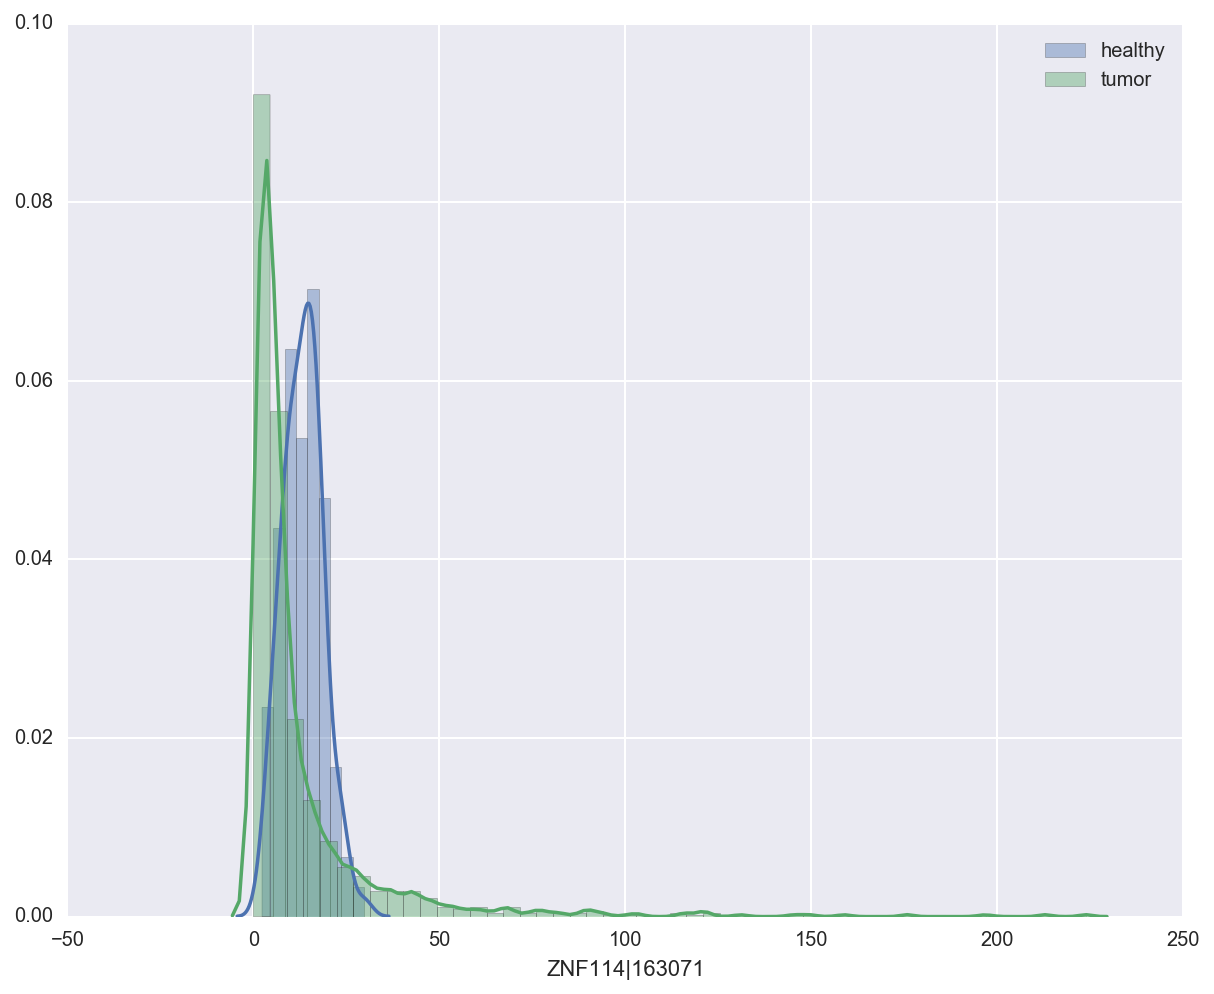

In [335]:
plt.figure(figsize=(10, 8))
sns.distplot(healthy[sample_row], label = 'healthy')
sns.distplot(tumor[sample_row], label = 'tumor')
plt.legend()

In [351]:
print 'tumor:', mode(tumor[sample_row]).mode[0]
print 'healthy:', mode(healthy[sample_row]).mode[0]

tumor: 0.0
healthy: 2.3211


In [496]:
successes = pymc.DiscreteUniform('successes', lower = 1, upper = 20)

p_successes = pymc.Uniform('p_success', 0, 1)

@deterministic()
def mu(p = p_successes, s = successes):
    return successes / p_successes - successes

alpha = successes

obs = pymc.NegativeBinomial('tumor', mu = mu, alpha = alpha, value = tumor[sample_row], observed = True)

In [485]:
model = pymc.Model([alpha, mu, obs])

map_ = pymc.MAP(model)
map_.fit()

mcmc = pymc.MCMC(model)
mcmc.sample(100000, 50000)

 [-----------------100%-----------------] 10000 of 10000 complete in 72.0 sec

1.0


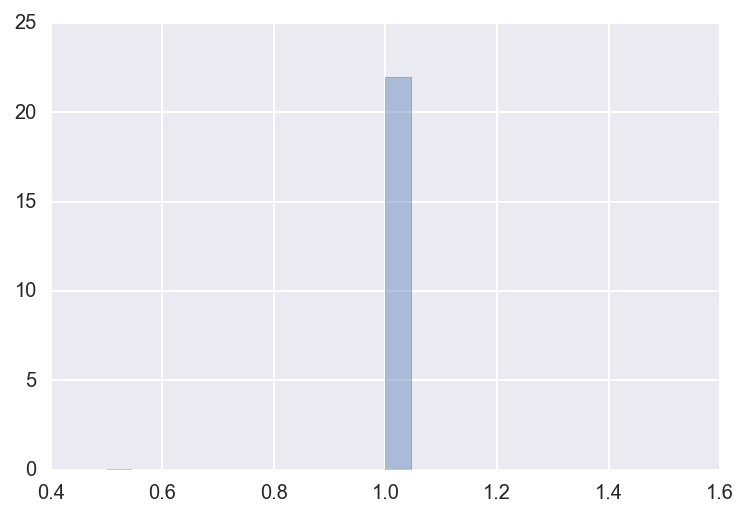

In [489]:
successes = mcmc.trace('successes')[:]
sns.distplot(successes)
print np.mean(successes)

0.0764084119518


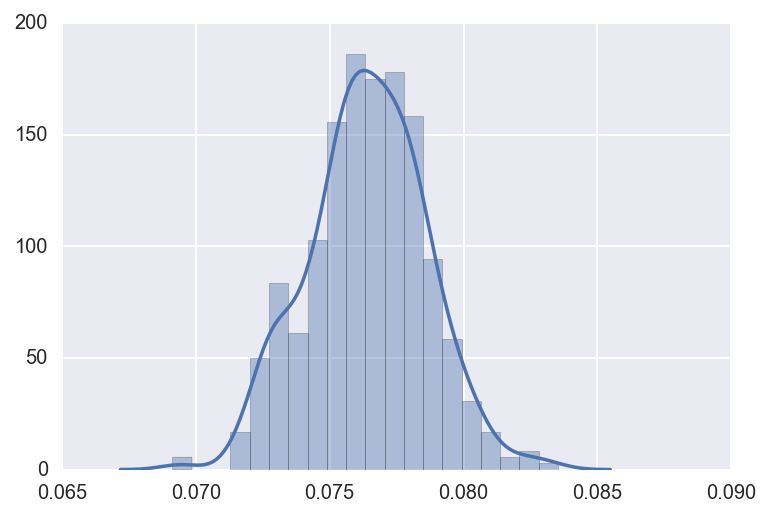

In [490]:
p_success = mcmc.trace('p_success')[:]
sns.distplot(p_success)
print np.mean(p_success)

1.0 0.0734513203783


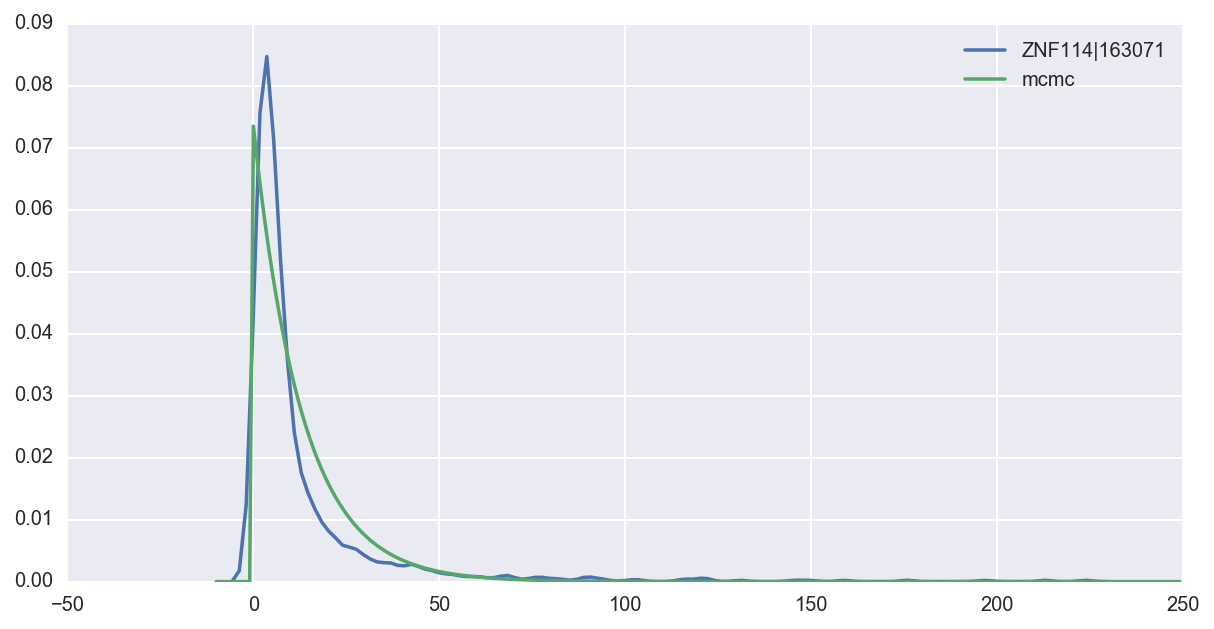

In [494]:
plt.figure(figsize=(10, 5))
sns.kdeplot(tumor[sample_row], shade = False)

n = np.mean(successes)
p = np.mean(p_successes)

print n, p

x = np.arange(-10, 250, 1)
pmf = scipy.stats.nbinom.pmf(x, n, p)
pylab.plot(x, pmf, label = 'mcmc')

# pmf = scipy.stats.nbinom.pmf(x, 3, 0.26)
# pylab.plot(x, pmf, label = 'empirical')

plt.legend()

Plotting successes
Plotting p_success


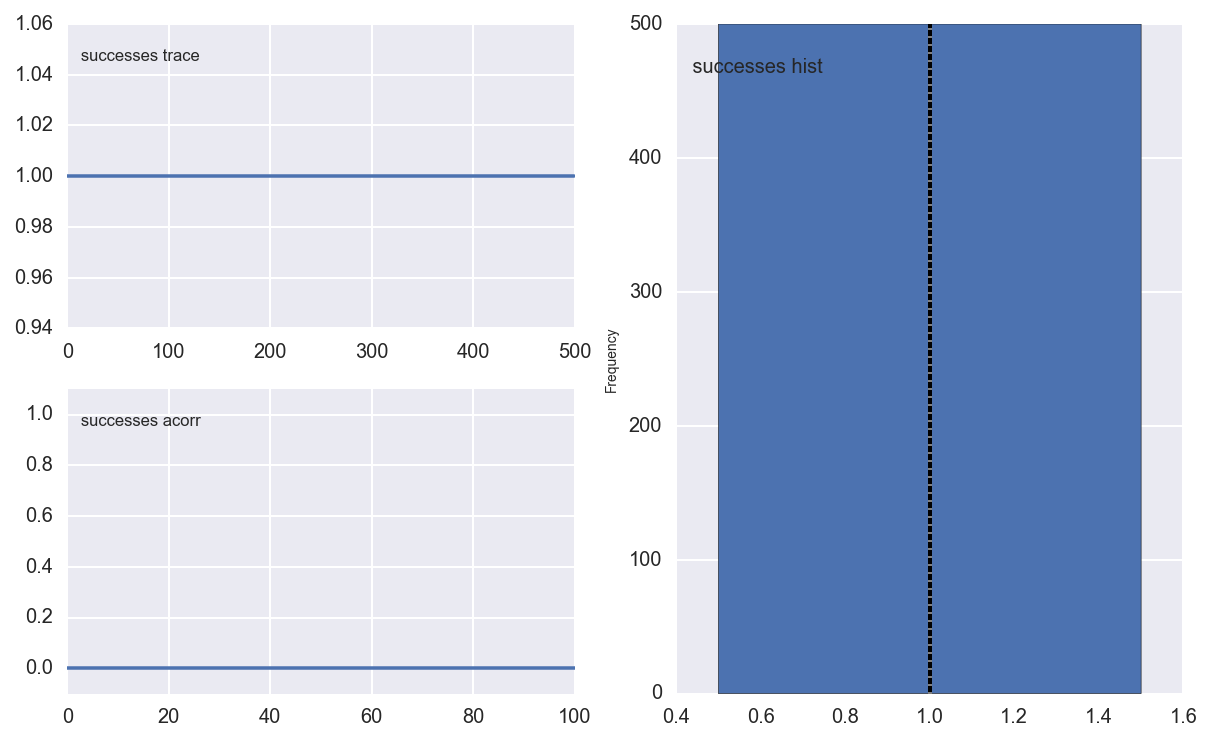

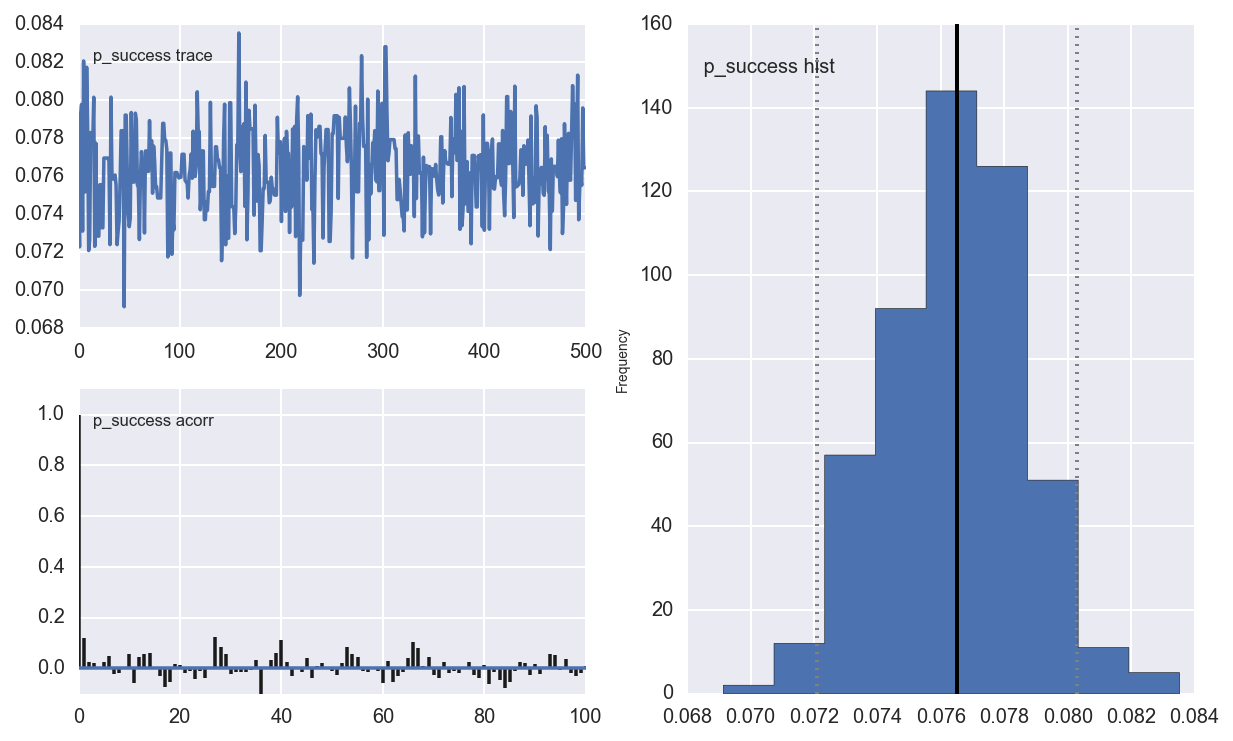

In [495]:
mcplot(mcmc.trace('successes'), common_scale=False)
mcplot(mcmc.trace('p_success'), common_scale=False)

ImportError: PyDot must be installed to use the graph function.
 PyDot is available from http://dkbza.org/pydot.html